# New York University: Deep Learning Final Project

## Building A More Context Aware Question Answering Model With QANet Architecture

### Introduction 

Traditional sequential question answering models often struggle to accurately understand and respond to questions that require a deeper understanding of context. To address this limitation, we propose a context-aware question answering model by extending the QANet architecture. Our model effectively models both local and global interactions in the input text, capturing rich contextual information.

In our experiments, we incorporated BERT embeddings into the input embedding layer, leveraging their success in capturing contextualized representations. We modified the model architecture to accommodate the larger dimensions of BERT embeddings. Additionally, we explored the impact of improving word embedding dimensions on the model's trainable parameters, training time, and the number of attention heads required for comparable or better performance.

Comparing our approach with using glove word embeddings, we observed that the best performing BERT-QANet model achieved an F-1 score of 61.23, while the Glove-QANet model tended to saturate at a lower F-1 score of 58.27. Due to hardware constraints, we limited the training to 20 epochs, with each epoch taking approximately 2 hours.

Our findings suggest that utilizing context-aware word embeddings has the potential to enhance the performance of the QANet model in question answering tasks. However, it is important to note that this improvement comes at the cost of increased training time.

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import re, os, string, typing, gc, json
import spacy
from collections import Counter
import torch
from transformers import BertTokenizer, BertModel

nlp = spacy.load('en_core_web_sm')


def load_json(path):
    '''
    Loads the JSON file of the Squad dataset.
    Returns the json object of the dataset.
    '''
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    print("Length of data: ", len(data['data']))
    print("Data Keys: ", data['data'][0].keys())
    print("Title: ", data['data'][0]['title'])
    
    return data




def parse_data(data:dict)->list:
    '''
    Parses the JSON file of Squad dataset by looping through the
    keys and values and returns a list of dictionaries with
    context, query and label triplets being the keys of each dict.
    '''
    data = data['data']
    qa_list = []

    for paragraphs in data:

        for para in paragraphs['paragraphs']:
            context = para['context']

            for qa in para['qas']:
                
                id = qa['id']
                question = qa['question']
                
                for ans in qa['answers']:
                    answer = ans['text']
                    ans_start = ans['answer_start']
                    ans_end = ans_start + len(answer)
                    
                    qa_dict = {}
                    qa_dict['id'] = id
                    qa_dict['context'] = context
                    qa_dict['question'] = question
                    qa_dict['label'] = [ans_start, ans_end]

                    qa_dict['answer'] = answer
                    qa_list.append(qa_dict)    

    
    return qa_list



def filter_large_examples(df):
    '''
    Returns ids of examples where context lengths, query lengths and answer lengths are
    above a particular threshold. These ids can then be dropped from the dataframe. 
    This is explicitly mentioned in QANet but can be done for other models as well.
    '''
    
    ctx_lens = []
    query_lens = []
    ans_lens = []
    for index, row in df.iterrows():
        ctx_tokens = [w.text for w in nlp(row.context, disable=['parser','ner','tagger'])]
        if len(ctx_tokens)>400:
            ctx_lens.append(row.name)

        query_tokens = [w.text for w in nlp(row.question, disable=['parser','tagger','ner'])]
        if len(query_tokens)>50:
            query_lens.append(row.name)

        ans_tokens = [w.text for w in nlp(row.answer, disable=['parser','tagger','ner'])]
        if len(ans_tokens)>30:
            ans_lens.append(row.name)

        assert row.name == index
    
    return set(ans_lens + ctx_lens + query_lens)


def gather_text_for_vocab(dfs:list):
    '''
    Gathers text from contexts and questions to build a vocabulary.
    
    :param dfs: list of dataframes of SQUAD dataset.
    :returns: list of contexts and questions
    '''
    
    text = []
    total = 0
    for df in dfs:
        unique_contexts = list(df.context.unique())
        unique_questions = list(df.question.unique())
        total += df.context.nunique() + df.question.nunique()
        text.extend(unique_contexts + unique_questions)
    
    assert len(text) == total
    
    return text




def build_word_vocab(vocab_text):
    '''
    Builds a word-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict word2idx: word to index mapping of words
        dict idx2word: integer to word mapping
        list word_vocab: list of words sorted by frequency
    '''
    
    
    words = []
    for sent in vocab_text:
        for word in nlp(sent, disable=['parser','tagger','ner']):
            words.append(word.text)

    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    print(f"raw-vocab: {len(word_vocab)}")
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    print(f"vocab-length: {len(word_vocab)}")
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    print(f"word2idx-length: {len(word2idx)}")
    idx2word = {v:k for k,v in word2idx.items()}
    
    
    return word2idx, idx2word, word_vocab





def build_char_vocab(vocab_text):
    '''
    Builds a character-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict char2idx: character to index mapping of words
        list char_vocab: list of characters sorted by frequency
    '''
    
    chars = []
    for sent in vocab_text:
        for ch in sent:
            chars.append(ch)

    char_counter = Counter(chars)
    char_vocab = sorted(char_counter, key=char_counter.get, reverse=True)
    print(f"raw-char-vocab: {len(char_vocab)}")
    high_freq_char = [char for char, count in char_counter.items() if count>=20]
    char_vocab = list(set(char_vocab).intersection(set(high_freq_char)))
    print(f"char-vocab-intersect: {len(char_vocab)}")
    char_vocab.insert(0,'<unk>')
    char_vocab.insert(1,'<pad>')
    char2idx = {char:idx for idx, char in enumerate(char_vocab)}
    print(f"char2idx-length: {len(char2idx)}")
    
    return char2idx, char_vocab



def context_to_ids(text, word2idx):
    '''
    Converts context text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: context text to be converted
    :param dict word2idx: word to id mapping

    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''
    
    context_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    context_ids = [word2idx[word] for word in context_tokens]
    
    assert len(context_ids) == len(context_tokens)
    return context_ids



    
def question_to_ids(text, word2idx):
    '''
    Converts question text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: question text to be converted
    :param dict word2idx: word to id mapping
    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''
    
    question_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    question_ids = [word2idx[word] for word in question_tokens]
    
    assert len(question_ids) == len(question_tokens)
    return question_ids
    


    
def test_indices(df, idx2word):
    '''
    Performs the tests mentioned above. This method also gets the start and end of the answers
    with respect to the context_ids for each example.
    
    :param dataframe df: SQUAD df
    :param dict idx2word: inverse mapping of token ids to words
    :returns
        list start_value_error: example idx where the start idx is not found in the start spans
                                of the text
        list end_value_error: example idx where the end idx is not found in the end spans
                              of the text
        list assert_error: examples that fail assertion errors. A majority are due to the above errors
        
    '''

    start_value_error = []
    end_value_error = []
    assert_error = []
    for index, row in df.iterrows():

        answer_tokens = [w.text for w in nlp(row['answer'], disable=['parser','tagger','ner'])]

        start_token = answer_tokens[0]
        end_token = answer_tokens[-1]
        
        context_span  = [(word.idx, word.idx + len(word.text)) 
                         for word in nlp(row['context'], disable=['parser','tagger','ner'])]

        starts, ends = zip(*context_span)

        answer_start, answer_end = row['label']

        try:
            start_idx = starts.index(answer_start)
        except:
            start_value_error.append(index)
        try:
            end_idx  = ends.index(answer_end)
        except:
            end_value_error.append(index)

        try:
            assert idx2word[row['context_ids'][start_idx]] == answer_tokens[0]
            assert idx2word[row['context_ids'][end_idx]] == answer_tokens[-1]
        except:
            assert_error.append(index)


    return start_value_error, end_value_error, assert_error



def get_error_indices(df, idx2word):
    
    start_value_error, end_value_error, assert_error = test_indices(df, idx2word)
    err_idx = start_value_error + end_value_error + assert_error
    err_idx = set(err_idx)
    print(f"Number of error indices: {len(err_idx)}")
    
    return err_idx



def index_answer(row, idx2word):
    '''
    Takes in a row of the dataframe or one training example and
    returns a tuple of start and end positions of answer by calculating 
    spans.
    '''
    
    context_span = [(word.idx, word.idx + len(word.text)) for word in nlp(row.context, disable=['parser','tagger','ner'])]
    starts, ends = zip(*context_span)
    
    answer_start, answer_end = row.label
    start_idx = starts.index(answer_start)
 
    end_idx  = ends.index(answer_end)
    
    ans_toks = [w.text for w in nlp(row.answer,disable=['parser','tagger','ner'])]
    ans_start = ans_toks[0]
    ans_end = ans_toks[-1]
    assert idx2word[row.context_ids[start_idx]] == ans_start
    assert idx2word[row.context_ids[end_idx]] == ans_end
    
    return [start_idx, end_idx]






/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from torch import nn
import torch
import numpy as np
import pandas as pd
import pickle, time
import re, os, string, typing, gc, json
import torch.nn.functional as F
import spacy
from sklearn.model_selection import train_test_split
from collections import Counter
nlp = spacy.load('en_core_web_sm')
# from preprocess import *
%load_ext autoreload
%autoreload 2

## Data preprocessing

In [ ]:
# # # load dataset json files

# train_data = load_json('/content/drive/MyDrive/Files-NLP/squad_train.json')
# valid_data = load_json('/content/drive/MyDrive/Files-NLP/squad_dev.json')

In [ ]:
# # parse the json structure to return the data as a list of dictionaries

# train_list = parse_data(train_data)
# #train_list = train_list[0:1500]
# valid_list = parse_data(valid_data)
# #valid_list = valid_list[0:100]

In [ ]:
# print('Train list len: ',len(train_list))
# print('Valid list len: ',len(valid_list))

In [ ]:
# # # converting the lists into dataframes

# train_df = pd.DataFrame(train_list)
# valid_df = pd.DataFrame(valid_list)

In [ ]:
# train_df.head()

In [ ]:
# # # get indices of outliers and drop them from the dataframe

# %time drop_ids_train = filter_large_examples(train_df)
# train_df.drop(list(drop_ids_train), inplace=True)

# %time drop_ids_valid = filter_large_examples(valid_df)
# valid_df.drop(list(drop_ids_valid), inplace=True)

In [ ]:
# # # gather text to build vocabularies

# vocab_text = gather_text_for_vocab([train_df, valid_df])
# print("Number of sentences in the dataset: ", len(vocab_text))

In [ ]:
# # # # build word and character-level vocabularies

# %time word2idx, idx2word, word_vocab = build_word_vocab(vocab_text)
# # print("----------------------------------")


In [ ]:
# %time char2idx, char_vocab = build_char_vocab(vocab_text)

In [ ]:
# # # numericalize context and questions for training and validation set

# %time train_df['context_ids'] = train_df.context.apply(context_to_ids, word2idx=word2idx)
# %time valid_df['context_ids'] = valid_df.context.apply(context_to_ids, word2idx=word2idx)
# %time train_df['question_ids'] = train_df.question.apply(question_to_ids, word2idx=word2idx)
# %time valid_df['question_ids'] = valid_df.question.apply(question_to_ids, word2idx=word2idx)

In [ ]:
# # # get indices with tokenization errors and drop those indices 

# train_err = get_error_indices(train_df, idx2word)
# valid_err = get_error_indices(valid_df, idx2word)

# train_df.drop(train_err, inplace=True)
# valid_df.drop(valid_err, inplace=True)

In [ ]:
# len(train_df), len(valid_df)

In [ ]:

# # get start and end positions of answers from the context
# # this is basically the label for training QA models

# train_label_idx = train_df.apply(index_answer, axis=1, idx2word=idx2word)
# valid_label_idx = valid_df.apply(index_answer, axis=1, idx2word=idx2word)

# train_df['label_idx'] = train_label_idx
# valid_df['label_idx'] = valid_label_idx

### Dump data to pickle files 
This ensures that we can directly access the preprocessed dataframe next time.

In [ ]:
# train_df.to_pickle('qanettrain_1500.pkl')
# valid_df.to_pickle('qanetvalid_1500.pkl')

In [ ]:
# import pickle
# with open('qanetw2id_1500.pickle','wb') as handle:
#     pickle.dump(word2idx, handle)

# with open('qanetc2id_1500.pickle','wb') as handle:
#     pickle.dump(char2idx, handle)

### Read data from pickle files

You only need to run the preprocessing once. Some preprocessing functions can take upto 3 mins. Therefore, pickling preprocessed data can save a lot of time.

In [ ]:

import pickle

with open('/kaggle/input/qanetdata/qanetw2id.pickle','rb') as handle:
    word2idx = pickle.load(handle)
with open('/kaggle/input/qanetdata/qanetc2id.pickle','rb') as handle:
    char2idx = pickle.load(handle)


In [ ]:
train_df = pd.read_pickle('/kaggle/input/qanetdata/qanettrain.pkl')
valid_df = pd.read_pickle('/kaggle/input/qanetdata/qanetvalid.pkl')

In [ ]:
idx2word = {v:k for k,v in word2idx.items()}

In [ ]:
import pickle

with open('/kaggle/input/qanetdata/word_vocab.pickle','rb') as handle:
    word_vocab = pickle.load(handle)


## Creating the dataloader

This class takes care of batching, creating character vectors and returns all the things needed during training.

In [ ]:
class SquadDataset:
    '''
    - Creates batches dynamically by padding to the length of largest example
      in a given batch.
    - Calulates character vectors for contexts and question.
    - Returns tensors for training.
    '''
    def __init__(self, data, batch_size):
        '''
        data: dataframe
        batch_size: int
        '''
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
        
        
    def __len__(self):
        return len(self.data)
    
    def make_char_vector(self, max_sent_len, sentence, max_word_len=16):
        
        char_vec = torch.zeros(max_sent_len, max_word_len).type(torch.LongTensor)
        
        for i, word in enumerate(nlp(sentence, disable=['parser','tagger','ner'])):
            for j, ch in enumerate(word.text):
                if j == max_word_len:
                    break
                char_vec[i][j] = char2idx.get(ch, 0)
        
        return char_vec     
    
    def get_span(self, text):

        text = nlp(text, disable=['parser','tagger','ner'])
        span = [(w.idx, w.idx+len(w.text)) for w in text]

        return span

    
    def __iter__(self):
        '''
        Creates batches of data and yields them.
        
        Each yield comprises of:
        :padded_context: padded tensor of contexts for each batch 
        :padded_question: padded tensor of questions for each batch 
        :char_ctx & ques_ctx: character-level ids for context and question
        :label: start and end index wrt context_ids
        :context_text,answer_text: used while validation to calculate metrics
        :ids: question_ids for evaluation
        '''
        
        for batch in self.data:
            
            spans = []
            ctx_text = []
            answer_text = []
            
             
            for ctx in batch.context:
                ctx_text.append(ctx)
                spans.append(self.get_span(ctx))
            
            for ans in batch.answer:
                answer_text.append(ans)
                
            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)
            
            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)
                
            max_word_ctx = 16
          
            char_ctx = torch.zeros(len(batch), max_context_len, max_word_ctx).type(torch.LongTensor)
            for i, context in enumerate(batch.context):
                char_ctx[i] = self.make_char_vector(max_context_len, context)
            
            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)
            
            for i, ques in enumerate(batch.question_ids):
                padded_question[i, :len(ques)] = torch.LongTensor(ques)
                
            max_word_ques = 16
            
            char_ques = torch.zeros(len(batch), max_question_len, max_word_ques).type(torch.LongTensor)
            for i, question in enumerate(batch.question):
                char_ques[i] = self.make_char_vector(max_question_len, question)
            
              
            label = torch.LongTensor(list(batch.label_idx))
            ids = list(batch.id)
            
            yield (padded_context, padded_question, char_ctx, char_ques, label, ctx_text, answer_text, ids)
            
            

In [ ]:
# create dataloaders

train_dataset = SquadDataset(train_df,16)
valid_dataset = SquadDataset(valid_df,16)

In [ ]:
# # looking at the shapes of various tensors returned by the loader

# a = next(iter(train_dataset))
# for i in range(len(a)):
#     try:
#         print(a[i].shape)
#     except AttributeError:
#         print(len(a[i]))

In [ ]:
# def get_glove_dict():
#     '''
#     Parses the glove word vectors text file and returns a dictionary with the words as
#     keys and their respective pretrained word vectors as values.

#     '''
#     glove_dict = {}
#     with open("/content/drive/MyDrive/Files-NLP/glove.840B.300d.txt", "r", encoding="utf-8") as f:
#         for line in f:
#             values = line.split(' ')
#             word = values[0]
#             vector = np.asarray(values[1:], dtype="float32")
#             glove_dict[word] = vector

#     f.close()
    
#     return glove_dict

In [ ]:
# glove_dict = get_glove_dict()

In [ ]:
# def create_weights_matrix(glove_dict):
#     '''
#     Creates a weight matrix of the words that are common in the GloVe vocab and
#     the dataset's vocab. Initializes OOV words with a zero vector.
#     '''
#     weights_matrix = np.zeros((len(word_vocab), 300))
#     words_found = 0
#     for i, word in enumerate(word_vocab):
#         try:
#             weights_matrix[i] = glove_dict[word]
#             words_found += 1
#         except:
#             pass

#     return weights_matrix, words_found
def create_weights_matrix():
  model = BertModel.from_pretrained('bert-base-uncased')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  #encoded_text = tokenizer.encode(tokenized_text)
  # with open('/content/drive/MyDrive/Files-NLP/squad_train.json', 'r') as f:
  #   squad_data = json.load(f)
  # # print(squad_data)
  # # Concatenate all contexts to form a large input text
  # input_text = ''
  # for article in squad_data['data']:
  #     for paragraph in article['paragraphs']:
  #         input_text += paragraph['context'] + ' '
  # # Tokenize the input text
  # tokenized_text = tokenizer.tokenize(input_text)

  # # Pass the tokenized input through the BERT model to obtain the embeddings
  # with torch.no_grad():
  #     encoded_text = tokenizer.encode(tokenized_text, add_special_tokens=False, return_tensors='pt')
  #     bert_embeddings = bert_model(encoded_text)[0].numpy()

  # Create a weight matrix using the BERT embeddings
  num_words = len(word_vocab)
  embedding_dim = model.config.hidden_size
  #weights_matrix = np.zeros((num_words, embedding_dim))
  weights_matrix = np.zeros((num_words, embedding_dim))

  #linear_layer = torch.nn.Linear(768, 300)


  # iterate over the words and obtain their embeddings
  for i, word in enumerate(word_vocab):
    # Tokenize the word using the BERT tokenizer
    tokenized_word = tokenizer.encode(word, add_special_tokens=False)

    # Convert the tokenized word to a PyTorch tensor
    input_ids = torch.tensor(tokenized_word).unsqueeze(0).long()

    # Get the embeddings from the BERT model
    with torch.no_grad():
      try:
        outputs = model(input_ids)
        #embeddings = outputs[0][:, 0, :]
        embeddings = outputs[0].mean(dim=1)

      except Exception as e:
        print("error")
        print(e)
        print(f"word is:{word}")
        #print(f"outputs:{outputs}")
        
    
    # Apply the linear layer to reduce the dimensionality of the embeddings
    #reduced_embeddings = linear_layer(embeddings).detach().numpy()

    # Add the embeddings to the dictionary
    weights_matrix[i] = embeddings
    #weights_matrix[i] = embeddings.numpy()
  return weights_matrix

In [ ]:
# weights_matrix = create_weights_matrix()
# # # print("Words found in the GloVe vocab: " ,words_found)

In [ ]:
# weights_matrix.shape

In [ ]:
# # # # save the weight matrix for future loading.
# # # # This matrix is the nn.Embedding's weight matrix.

# np.save('qanetbert_vt_300_all.npy', weights_matrix)

In [ ]:
# word_vocab

## Model

In [ ]:
class DepthwiseSeparableConvolution(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, dim=1):
        
        super().__init__()
        self.dim = dim
        if dim == 2:
            
            self.depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                        kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2)
        
            self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        
    
        else:
        
            self.depthwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels,
                                            kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2,
                                            bias=False)

            self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=True)

    
    def forward(self, x):
        # x = [bs, seq_len, emb_dim]
        if self.dim == 1:
            x = x.transpose(1,2)
            x = self.pointwise_conv(self.depthwise_conv(x))
            x = x.transpose(1,2)
        else:
            x = self.pointwise_conv(self.depthwise_conv(x))
        #print("DepthWiseConv output: ", x.shape)
        return x

In [ ]:

class HighwayLayer(nn.Module):
    
    def __init__(self, layer_dim, num_layers=2):
    
        super().__init__()
        self.num_layers = num_layers
        
        self.flow_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
        self.gate_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
    
    def forward(self, x):
        #print("Highway input: ", x.shape)
        for i in range(self.num_layers):
            
            flow = self.flow_layers[i](x)
            gate = torch.sigmoid(self.gate_layers[i](x))
            
            x = gate * flow + (1 - gate) * x
            
        #print("Highway output: ", x.shape)
        return x

In [ ]:
class EmbeddingLayer(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, kernel_size, device):
        
        super().__init__()
        
        self.device = device
        
        self.char_embedding = nn.Embedding(char_vocab_dim, char_emb_dim)
        
        self.word_embedding = self.get_glove_word_embedding()
        
        self.conv2d = DepthwiseSeparableConvolution(char_emb_dim, char_emb_dim, kernel_size,dim=2)
        
        self.highway = HighwayLayer(self.word_emb_dim + char_emb_dim)
    
        
    def get_glove_word_embedding(self):
        
        #weights_matrix = np.load('/content/qanetbert_vt_300.npy')
        #weights_matrix = np.load('/kaggle/input/qanetdata/qanetbert_vt_300.npy')
        weights_matrix = np.load('/kaggle/input/bert300all/qanetbert_vt_300_all.npy')

        # print("Weights matrix loaded...")
        num_embeddings, embedding_dim = weights_matrix.shape
        # print(f"Num embeddings : {num_embeddings}")
        self.word_emb_dim = embedding_dim
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device),freeze=True)
        # print(embedding)
        print("Got embeddings...")

        return embedding
    
    def forward(self, x, x_char):
        # x = [bs, seq_len]
        # x_char = [bs, seq_len, word_len(=16)]
        
        word_emb = self.word_embedding(x)
        # print(word_emb)
        # word_emb = [bs, seq_len, word_emb_dim]
        
        word_emb = F.dropout(word_emb,p=0.1)
        
        char_emb = self.char_embedding(x_char)
        # char_embed = [bs, seq_len, word_len, char_emb_dim]
        
        char_emb = F.dropout(char_emb.permute(0,3,1,2), p=0.05)
        # [bs, char_emb_dim, seq_len, word_len] == [N, Cin, Hin, Win]
        
        conv_out = F.relu(self.conv2d(char_emb))
        # [bs, char_emb_dim, seq_len, word_len] 
        # the depthwise separable conv does not change the shape of the input
        
        char_emb, _ = torch.max(conv_out, dim=3)
        # [bs, char_emb_dim, seq_len]
        
        char_emb = char_emb.permute(0,2,1)
        # [bs, seq_len, char_emb_dim]
        
        concat_emb = torch.cat([char_emb, word_emb], dim=2)
        # [bs, seq_len, char_emb_dim + word_emb_dim]
        
        emb = self.highway(concat_emb)
        # [bs, seq_len, char_emb_dim + word_emb_dim]
        
        #print("Embedding output: ", emb.shape)
        return emb

In [ ]:
class MultiheadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, num_heads, device):
        
        super().__init__()
        self.num_heads = num_heads
        self.device = device
        self.hid_dim = hid_dim
        
        self.head_dim = self.hid_dim // self.num_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        
    def forward(self, x, mask):
        # x = [bs, len_x, hid_dim]
        # mask = [bs, len_x]
        
        batch_size = x.shape[0]
        
        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)
        # Q = K = V = [bs, len_x, hid_dim]
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        # [bs, len_x, num_heads, head_dim ]  => [bs, num_heads, len_x, head_dim]
        
        K = K.permute(0,1,3,2)
        # [bs, num_heads, head_dim, len_x]
        
        energy = torch.matmul(Q, K) / self.scale
        # (bs, num_heads){[len_x, head_dim] * [head_dim, len_x]} => [bs, num_heads, len_x, len_x]
        
        mask = mask.unsqueeze(1).unsqueeze(2)
        # [bs, 1, 1, len_x]
        
        #print("Mask: ", mask)
        #print("Energy: ", energy)
        
        energy = energy.masked_fill(mask == 1, -1e10)
        
        #print("energy after masking: ", energy)
        
        alpha = torch.softmax(energy, dim=-1)
        #  [bs, num_heads, len_x, len_x]
        
        #print("energy after smax: ", alpha)
        alpha = F.dropout(alpha, p=0.1)
        
        a = torch.matmul(alpha, V)
        # [bs, num_heads, len_x, head_dim]
        
        a = a.permute(0,2,1,3)
        # [bs, len_x, num_heads, hid_dim]
        
        a = a.contiguous().view(batch_size, -1, self.hid_dim)
        # [bs, len_x, hid_dim]
        
        a = self.fc_o(a)
        # [bs, len_x, hid_dim]
        
        #print("Multihead output: ", a.shape)
        return a

In [ ]:
from torch.autograd import Variable
import math

In [ ]:
class PositionEncoder(nn.Module):
    
    def __init__(self, model_dim, device, max_length=400):
        
        super().__init__()
        
        self.device = device
        
        self.model_dim = model_dim
        
        pos_encoding = torch.zeros(max_length, model_dim)
        
        for pos in range(max_length):
            
            for i in range(0, model_dim, 2):
                
                pos_encoding[pos, i] = math.sin(pos / (10000 ** ((2*i)/model_dim)))
                pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2*(i+1))/model_dim)))
            
        
        pos_encoding = pos_encoding.unsqueeze(0).to(device)
        self.register_buffer('pos_encoding', pos_encoding)
        
    
    def forward(self, x):
        #print("PE shape: ", self.pos_encoding.shape)
        #print("PE input: ", x.shape)
        x = x + Variable(self.pos_encoding[:, :x.shape[1]], requires_grad=False)
        #print("PE output: ", x.shape)
        return x

In [ ]:
class EncoderBlock(nn.Module):
    
    def __init__(self, model_dim, num_heads, num_conv_layers, kernel_size, device):
        
        super().__init__()
        
        self.num_conv_layers = num_conv_layers
        
        self.conv_layers = nn.ModuleList([DepthwiseSeparableConvolution(model_dim, model_dim, kernel_size)
                                          for _ in range(num_conv_layers)])
        
        self.multihead_self_attn = MultiheadAttentionLayer(model_dim, num_heads, device)
        
        self.position_encoder = PositionEncoder(model_dim, device)
        
        self.pos_norm = nn.LayerNorm(model_dim)
        
        self.conv_norm = nn.ModuleList([nn.LayerNorm(model_dim) for _ in range(self.num_conv_layers)])
        
        self.feedfwd_norm = nn.LayerNorm(model_dim)
        
        self.feed_fwd = nn.Linear(model_dim, model_dim)
        
    def forward(self, x, mask):
        # x = [bs, len_x, model_dim]
        # mask = [bs, len_x]
        
        out = self.position_encoder(x)
        # [bs, len_x, model_dim]
        
        res = out
        
        out = self.pos_norm(out)
        # [bs, len_x, model_dim]
        
        for i, conv_layer in enumerate(self.conv_layers):
            
            out = F.relu(conv_layer(out))
            out = out + res
            if (i+1) % 2 == 0:
                out = F.dropout(out, p=0.1)
            res = out
            out = self.conv_norm[i](out)
        
        
        out = self.multihead_self_attn(out, mask)
        # [bs, len_x, model_dim]
        
        out = F.dropout(out + res, p=0.1)
        
        res = out
        
        out = self.feedfwd_norm(out)
        
        out = F.relu(self.feed_fwd(out))
        # [bs, len_x, model_dim]
            
        out = F.dropout(out + res, p=0.1)
        # [bs, len_x, model_dim]
        #print("Encoder block output: ", out.shape)
        return out

In [ ]:
class ContextQueryAttentionLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__() 
        
        self.W0 = nn.Linear(3*model_dim, 1, bias=False)
        
    def forward(self, C, Q, c_mask, q_mask):
        # C = [bs, ctx_len, model_dim]
        # Q = [bs, qtn_len, model_dim]
        # c_mask = [bs, ctx_len]
        # q_mask = [bs, qtn_len]
        
        c_mask = c_mask.unsqueeze(2)
        # [bs, ctx_len, 1]
        
        q_mask = q_mask.unsqueeze(1)
        # [bs, 1, qtn_len]
        
        ctx_len = C.shape[1]
        qtn_len = Q.shape[1]
        
        C_ = C.unsqueeze(2).repeat(1,1,qtn_len,1)
        # [bs, ctx_len, qtn_len, model_dim] 
        
        Q_ = Q.unsqueeze(1).repeat(1,ctx_len,1,1)
        # [bs, ctx_len, qtn_len, model_dim]
        
        C_elemwise_Q = torch.mul(C_, Q_)
        # [bs, ctx_len, qtn_len, model_dim]
        
        S = torch.cat([C_, Q_, C_elemwise_Q], dim=3)
        # [bs, ctx_len, qtn_len, model_dim*3]
        
        S = self.W0(S).squeeze()
        #print("Simi matrix: ", S.shape)
        # [bs, ctx_len, qtn_len, 1] => # [bs, ctx_len, qtn_len]
        
        S_row = S.masked_fill(q_mask==1, -1e10)
        S_row = F.softmax(S_row, dim=2)
        
        S_col = S.masked_fill(c_mask==1, -1e10)
        S_col = F.softmax(S_col, dim=1)
        
        A = torch.bmm(S_row, Q)
        # (bs)[ctx_len, qtn_len] X [qtn_len, model_dim] => [bs, ctx_len, model_dim]
        
        B = torch.bmm(torch.bmm(S_row,S_col.transpose(1,2)), C)
        # [ctx_len, qtn_len] X [qtn_len, ctx_len] => [bs, ctx_len, ctx_len]
        # [ctx_len, ctx_len] X [ctx_len, model_dim ] => [bs, ctx_len, model_dim]
        
        model_out = torch.cat([C, A, torch.mul(C,A), torch.mul(C,B)], dim=2)
        # [bs, ctx_len, model_dim*4]
        
        #print("C2Q output: ", model_out.shape)
        return F.dropout(model_out, p=0.1)
        
        

In [ ]:
class OutputLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__()
        
        self.W1 = nn.Linear(2*model_dim, 1, bias=False)
        
        self.W2 = nn.Linear(2*model_dim, 1, bias=False)
        
        
    def forward(self, M1, M2, M3, c_mask):
        
        start = torch.cat([M1,M2], dim=2)
        
        start = self.W1(start).squeeze()
        
        p1 = start.masked_fill(c_mask==1, -1e10)
        
        #p1 = F.log_softmax(start.masked_fill(c_mask==1, -1e10), dim=1)
        
        end = torch.cat([M1, M3], dim=2)
        
        end = self.W2(end).squeeze()
        
        p2 = end.masked_fill(c_mask==1, -1e10)
        
        #p2 = F.log_softmax(end.masked_fill(c_mask==1, -1e10), dim=1)
        
        #print("preds: ", [p1.shape,p2.shape])
        return p1, p2
        

In [ ]:
class QANet(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, word_emb_dim, kernel_size, model_dim, num_heads, device):
        
        super().__init__()
        
        self.embedding = EmbeddingLayer(char_vocab_dim, char_emb_dim, kernel_size, device)
        
        self.ctx_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.qtn_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.embedding_encoder = EncoderBlock(model_dim, num_heads, 4, 5, device)
        
        self.c2q_attention = ContextQueryAttentionLayer(model_dim)
        
        self.c2q_resizer = DepthwiseSeparableConvolution(model_dim*4, model_dim, 5)
        
        self.model_encoder_layers = nn.ModuleList([EncoderBlock(model_dim, num_heads, 2, 5, device)
                                                   for _ in range(7)])
        
        self.output = OutputLayer(model_dim)
        
        self.device=device
    
    def forward(self, ctx, qtn, ctx_char, qtn_char):
        
        c_mask = torch.eq(ctx, 1).float().to(self.device)
        q_mask = torch.eq(qtn, 1).float().to(self.device)
        
        ctx_emb = self.embedding(ctx, ctx_char)
        # [bs, ctx_len, ch_emb_dim + word_emb_dim]
        
        ctx_emb = self.ctx_resizer(ctx_emb)
        #  [bs, ctx_len, model_dim]
        
        qtn_emb = self.embedding(qtn, qtn_char)
        # [bs, ctx_len, ch_emb_dim + word_emb_dim]
        
        qtn_emb = self.qtn_resizer(qtn_emb)
        # [bs, qtn_len, model_dim]
        
        C = self.embedding_encoder(ctx_emb, c_mask)
        # [bs, ctx_len, model_dim]
        
        Q = self.embedding_encoder(qtn_emb, q_mask)
        # [bs, qtn_len, model_dim]
            
        C2Q = self.c2q_attention(C, Q, c_mask, q_mask)
        # [bs, ctx_len, model_dim*4]
        
        M1 = self.c2q_resizer(C2Q)
        # [bs, ctx_len, model_dim]
    
        for layer in self.model_encoder_layers:
            M1 = layer(M1, c_mask)
        
        M2 = M1
        # [bs, ctx_len, model_dim]  
        
        for layer in self.model_encoder_layers:
            M2 = layer(M2, c_mask)
        
        M3 = M2
        # [bs, ctx_len, model_dim]
        
        for layer in self.model_encoder_layers:
            M3 = layer(M3, c_mask)
            
        p1, p2 = self.output(M1, M2, M3, c_mask)
        
        return p1, p2

In [ ]:
CHAR_VOCAB_DIM = len(char2idx)
CHAR_EMB_DIM = 200
WORD_EMB_DIM = 768
KERNEL_SIZE = 5
MODEL_DIM = 128
NUM_ATTENTION_HEADS = 1
device = torch.device('cuda')
# device = "cpu"

model = QANet(CHAR_VOCAB_DIM,
              CHAR_EMB_DIM, 
              WORD_EMB_DIM,
              KERNEL_SIZE,
              MODEL_DIM,
              NUM_ATTENTION_HEADS, device).to(device)
              
# device).to(device)

Got embeddings...


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,148,952 trainable parameters


## Training

> *We use the ADAM optimizer (Kingma & Ba, 2014) with β1 = 0.8,β2 = 0.999, $\epsilon$ = 10−7. We use a learning rate warm-up scheme with an inverse exponential increase from 0.0 to 0.001 in the ﬁrst 1000 steps, and then maintain a constant learning rate for the remainder of training.*


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), betas=(0.8,0.999), eps=10e-7, weight_decay=3*10e-7)

In [ ]:
def train(model, train_dataset):
    print("Starting training ........")
   

    train_loss = 0.
    batch_count = 0

    for batch in train_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch: {batch_count}")
            
#         if batch_count >= 50:
#             print(f"Starting batch: {batch_count}")
#             break
            
        batch_count += 1
        
        context, question, char_ctx, char_ques, label, ctx_text, ans, ids = batch
        
        # place data on GPU
        context, question, char_ctx, char_ques, label = context.to(device), question.to(device),\
                                    char_ctx.to(device), char_ques.to(device), label.to(device)
        
        # forward pass, get predictions
        preds = model(context, question, char_ctx, char_ques)

        start_pred, end_pred = preds
        
        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]
        
        # calculate loss
        loss = F.cross_entropy(start_pred, start_label) + F.cross_entropy(end_pred, end_label)
        
        # backward pass
        loss.backward()
        
        # update the gradients
        optimizer.step()

        # zero the gradients so that they do not accumulate
        optimizer.zero_grad()

        train_loss += loss.item()
        

    return train_loss/len(train_dataset)
    #return train_loss/500


In [ ]:
def valid(model, valid_dataset):
    
    print("Starting validation .........")
   
    valid_loss = 0.

    batch_count = 0
    
    f1, em = 0., 0.
    
    predictions = {}
    
    for batch in valid_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch {batch_count}")
        
#         if batch_count >= 50:
#             print(f"Starting batch {batch_count}")
#             break
            
        
        batch_count += 1

        context, question, char_ctx, char_ques, label, ctx_text, ans, ids = batch

        context, question, char_ctx, char_ques, label = context.to(device), question.to(device),\
                                    char_ctx.to(device), char_ques.to(device), label.to(device)

        with torch.no_grad():

            preds = model(context, question, char_ctx, char_ques)

            p1, p2 = preds

            y1, y2 = label[:,0], label[:,1]

            loss = F.nll_loss(p1, y1) + F.nll_loss(p2, y2)

            valid_loss += loss.item()

            batch_size, c_len = p1.size()
            ls = nn.LogSoftmax(dim=1)
            mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
            score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
            score, s_idx = score.max(dim=1)
            score, e_idx = score.max(dim=1)
            s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()
            
           
            for i in range(batch_size):
                id = ids[i]
                pred = context[i][s_idx[i]:e_idx[i]+1]
                pred = ' '.join([idx2word[idx.item()] for idx in pred])
                predictions[id] = pred
            
            
    em, f1 = evaluate(predictions)
    return valid_loss/len(valid_dataset), em, f1           
  

In [ ]:
def evaluate(predictions):
    '''
    Gets a dictionary of predictions with question_id as key
    and prediction as value. The validation dataset has multiple 
    answers for a single question. Hence we compare our prediction
    with all the answers and choose the one that gives us
    the maximum metric (em or f1). 
    This method first parses the JSON file, gets all the answers
    for a given id and then passes the list of answers and the 
    predictions to calculate em, f1.
    
    
    :param dict predictions
    Returns
    : exact_match: 1 if the prediction and ground truth 
      match exactly, 0 otherwise.
    : f1_score: 
    '''
    with open('/kaggle/input/qanetdata/squad_dev.json','r',encoding='utf-8') as f:
        dataset = json.load(f)
        
    dataset = dataset['data']
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    continue
                
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                
                prediction = predictions[qa['id']]
                
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)
                
    
    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total
    
    return exact_match, f1



In [ ]:
def normalize_answer(s):
    '''
    Performs a series of cleaning steps on the ground truth and 
    predicted answer.
    '''
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    Returns maximum value of metrics for predicition by model against
    multiple ground truths.
    
    :param func metric_fn: can be 'exact_match_score' or 'f1_score'
    :param str prediction: predicted answer span by the model
    :param list ground_truths: list of ground truths against which
                               metrics are calculated. Maximum values of 
                               metrics are chosen.
                            
    
    '''
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
        
    return max(scores_for_ground_truths)


def f1_score(prediction, ground_truth):
    '''
    Returns f1 score of two strings.
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    Returns exact_match_score of two strings.
    '''
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def epoch_time(start_time, end_time):
    '''
    Helper function to record epoch time.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# len(train_dataset)/16,len(valid_dataset)/16



In [ ]:

train_losses = []
valid_losses = []
ems = []
f1s = []
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    start_time = time.time()
    print("hit")
    train_loss = train(model, train_dataset)
    valid_loss, em, f1 = valid(model, valid_dataset)
    torch.save(model.state_dict(),f'model_epoch{epoch+1}.pt')
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    ems.append(em)
    f1s.append(f1)
    
    print(f"Epoch train loss : {train_loss}| Time: {epoch_mins}m {epoch_secs}s")
    print(f"Epoch valid loss: {valid_loss}")
    print(f"Epoch EM: {em}")
    print(f"Epoch F1: {f1}")
    
    print("====================================================================================")
    

Epoch 1
hit
Starting training ........


/opt/conda/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 8.952268703582883| Time: 72m 31s
Epoch valid loss: 0.7911820792238897
Epoch EM: 8.684957426679281
Epoch F1: 16.637094249372165
Epoch 2
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 6.609179128255916| Time: 72m 32s
Epoch valid loss: -0.5693741065847902
Epoch EM: 13.774834437086092
Epoch F1: 22.642530688090808
Epoch 3
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 6.085314383927903| Time: 72m 56s
Epoch valid loss: -1.5119412317364849
Epoch EM: 15.799432355723747
Epoch F1: 24.968747331589253
Epoch 4
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 5.756133742187668| Time: 72m 11s
Epoch valid loss: -0.4124700889376128
Epoch EM: 17.105014191106907
Epoch F1: 26.608757551654698
Epoch 5
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 5.481726421799578| Time: 72m 7s
Epoch valid loss: -1.0433240870442329
Epoch EM: 19.640491958372753
Epoch F1: 28.87996933716677
Epoch 6
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 5.2155369205444835| Time: 71m 36s
Epoch valid loss: -0.9795680497672427
Epoch EM: 22.034058656575212
Epoch F1: 32.249496054888766
Epoch 7
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 4.930713305272916| Time: 72m 17s
Epoch valid loss: -2.0901983374860924
Epoch EM: 24.98580889309366
Epoch F1: 35.375268605117604
Epoch 8
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 4.658193145939827| Time: 72m 7s
Epoch valid loss: -0.8792705995061308
Epoch EM: 27.672658467360453
Epoch F1: 38.555971133225334
Epoch 9
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


Starting batch 2000


Epoch train loss : 4.432626210137928| Time: 71m 22s
Epoch valid loss: -2.292659145747552
Epoch EM: 29.110690633869442
Epoch F1: 40.08538293270596
Epoch 10
hit
Starting training ........


Starting batch: 0


Starting batch: 500


Starting batch: 1000


Starting batch: 1500


Starting batch: 2000


Starting batch: 2500


Starting batch: 3000


Starting batch: 3500


Starting batch: 4000


Starting batch: 4500


Starting batch: 5000


Starting validation .........


Starting batch 0


Starting batch 500


Starting batch 1000


Starting batch 1500


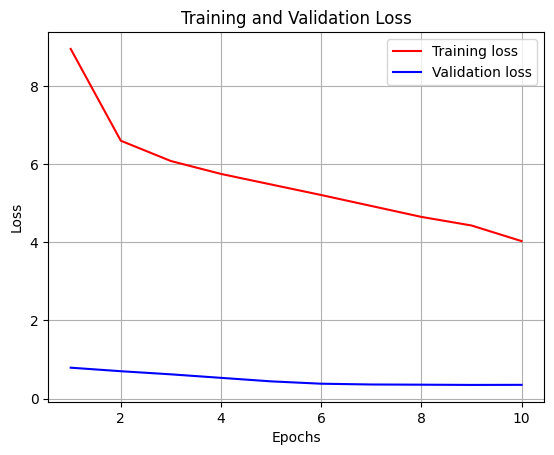

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  
plt.legend()
plt.show()

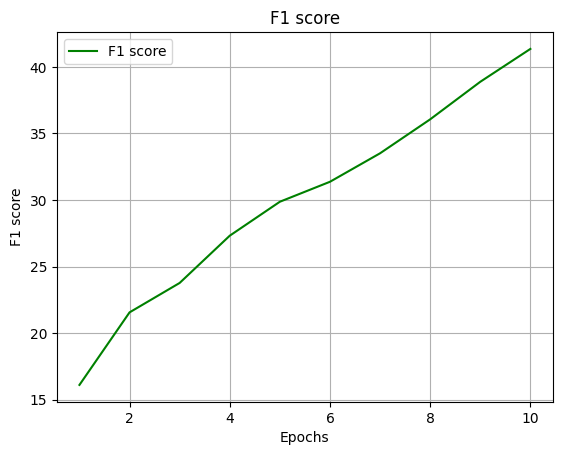

In [2]:
epochs = range(1, len(f1s) + 1)
plt.plot(epochs, f1s, 'g', label='F1 score')
plt.title('F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.grid(True)  
plt.legend()
plt.show()

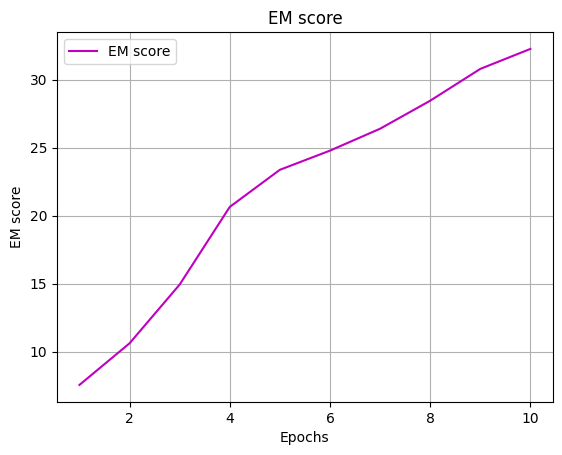

In [3]:
epochs = range(1, len(ems) + 1)
plt.plot(epochs, ems, 'm', label='EM score')
plt.title('EM score')
plt.xlabel('Epochs')
plt.ylabel('EM score')
plt.grid(True)  
plt.legend()
plt.show()

In [ ]:

with open('train_loss.pickle','wb') as handle:
    pickle.dump(train_losses, handle)

with open('valid_loss.pickle','wb') as handle:
    pickle.dump(valid_losses, handle)
    
with open('ems.pickle','wb') as handle:
    pickle.dump(ems, handle)
    
with open('f1s.pickle','wb') as handle:
    pickle.dump(f1s, handle)